In [2]:
import torch
import wandb
import datasets 
import numpy as np
from tqdm import tqdm
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torch.utils.data.dataset import Dataset
from transformers import PreTrainedTokenizerFast
from transformers import RobertaForSequenceClassification
from sklearn.metrics import classification_report, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os 
import warnings
from os import PathLike

api = wandb.Api()
artifact = api.artifact('henry-williams/opcode-malberta/model-e1tosi4k:v1', type='model')
artifact_dir = artifact.download()

warnings.filterwarnings("ignore")

device = torch.device('mps')
dataset = datasets.load_from_disk('../data/raw')
tokenizer = PreTrainedTokenizerFast.from_pretrained("../MalBERTa")
model = RobertaForSequenceClassification.from_pretrained(artifact_dir).to(device)

BATCH_SIZE = 256

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact model-e1tosi4k:v1, 87.83MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.8


In [ ]:
def make_preds(sample):
    input = tokenizer(
        sample,
        padding='max_length',
        max_length=32,
        return_overflowing_tokens=True,
        truncation=True,
        return_special_tokens_mask=True,
    )
    input_ids = torch.tensor(input['input_ids'])
    attention_mask = torch.tensor(input['attention_mask'])
    full_logits = []

    for ids, mask in zip(input_ids.split(BATCH_SIZE), attention_mask.split(BATCH_SIZE)):
        torch.mps.empty_cache()
        with torch.no_grad():
            logits = model(ids.to(device), mask.to(device)).logits
        full_logits.append(logits)

    logits = torch.vstack(full_logits)
    return logits

def make_ds():
    model.eval()

    predictions = []
    actuals = []

    for i, sample in enumerate(tqdm(dataset['test'], position=0)):
        logits = make_preds(sample['text']).unsqueeze(0)
        
        predictions.append(logits)
        actuals.append(sample['label'])
    return predictions, actuals 

In [ ]:
class PredictionsDataset(Dataset):
    def __init__(self, preds, labels):
        if len(preds) != len(labels):
            raise ValueError("Mismatch in size between x and y")

        self.preds = preds 
        self.labels = labels 
    
    def __len__(self):
        return len(self.preds)

    def __getitem__(self, index):
        return self.preds[index], self.labels[index]

if not os.path.exists('logits-ds.pt'):
    predictions, actuals = make_ds()
    d = PredictionsDataset(predictions, actuals)
    torch.save(d, 'logits-ds.pt')
else: 
    d = torch.load('logits-ds.pt', weights_only=False)


# LSTM Based 

In [ ]:
class Reducer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Reducer, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        z = self.fc(out[:, -1, :])
        return z

In [ ]:
r = Reducer(2, 32, 3)
r = r.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(r.parameters())

loss_history = []

for logits, label in tqdm(d):
    torch.mps.empty_cache()
    actual = F.one_hot(torch.tensor(torch.tensor(label)), 2).unsqueeze(0).to(torch.float32).to(device)
    
    optimizer.zero_grad()
    predicted = r(logits)
    loss = criterion(predicted, actual)
    loss_history.append(loss)
    loss.backward() 
    
    optimizer.step()

In [ ]:
plt.plot(torch.tensor(loss_history))

# Mean Logits

In [ ]:
def reduce(preds): 
    return preds.mean(dim=1).argmax(dim=1)

predicted, actual = [], []

for preds, label in tqdm(d, leave=False): 
    predicted.append(reduce(preds))    
    actual.append(label)    

print(classification_report(actual, torch.tensor(predicted).cpu()))

precision    recall  f1-score   support

           0       0.99      0.90      0.94       704
           1       0.91      0.99      0.95       684

    accuracy                           0.95      1388
   macro avg       0.95      0.95      0.95      1388
weighted avg       0.95      0.95      0.95      1388

In [ ]:
def reduce(preds): 
    return F.softmax(preds, dim=2).mean(dim=1).argmax()

predicted, actual = [], []

for preds, label in tqdm(d, leave=False): 
    predicted.append(reduce(preds))    
    actual.append(label)    

print(classification_report(actual, torch.tensor(predicted).cpu()))

precision    recall  f1-score   support

           0       0.99      0.90      0.94       704
           1       0.91      0.99      0.95       684

    accuracy                           0.94      1388
   macro avg       0.95      0.94      0.94      1388
weighted avg       0.95      0.94      0.94      1388

# Majority Voting

In [ ]:
def get_class_votes(preds):
    votes = preds.argmax(dim=-1)

    mal_votes = torch.count_nonzero(votes)
    ben_votes = votes.numel() - mal_votes

    return ben_votes, mal_votes

def get_class(preds):
    ben_votes, mal_votes = get_class_votes(preds)    

    return 0 if ben_votes > mal_votes else 1

predicted, actual = [], []

for preds, label in tqdm(d, leave=False): 
    predicted.append(get_class(preds))    
    actual.append(label)    

print(classification_report(actual, predicted))

precision    recall  f1-score   support

           0       0.99      0.88      0.93       704
           1       0.89      0.99      0.94       684

    accuracy                           0.94      1388
   macro avg       0.94      0.94      0.94      1388
weighted avg       0.94      0.94      0.94      1388

# KL-Divergence Certainty Based

In [ ]:
def get_certainty(preds):
    preds = F.softmax(preds.squeeze(0).cpu(), dim=1)
    return torch.tensor([torch.sum(p * torch.log(p / torch.full_like(p, 0.5))) for p in preds])

certainty = []
for p, _ in tqdm(d): 
    certainty.append(get_certainty(p)) 
certainty= np.array(certainty)
print(certainty.mean(), certainty.std())

100%|██████████| 1388/1388 [00:40<00:00, 34.27it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1388,) + inhomogeneous part.

In [ ]:
certainty = [c.mean() for c in certainty]

In [ ]:
certainty = np.array(certainty)

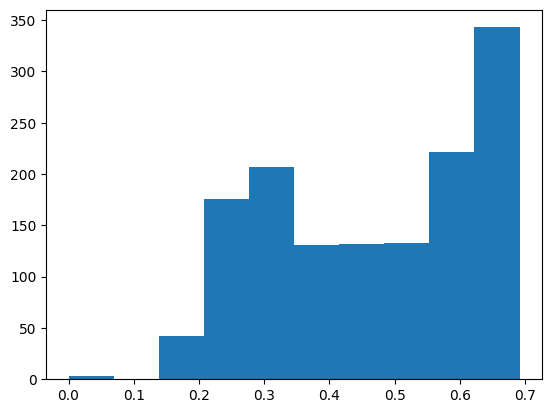

In [ ]:
plt.hist(certainty)
plt.show()